# Environment Setup

Github: https://github.com/eldadHaber/StructuralGeo

Installation instructions can be found in the repo Readme. For this notebook, the project is installed using an access token. PyTorch is also required to use the torch dataset.

# GeoGen Workshop

This notebook is designed to give a basic overview of the features of the GeoGen library and how to adapt and refine the accompanying dataloader.

The library can be seperated into two main components:

1.   A parameter driven geo-modelling framework: the computational engine, and
2.   A randomization scheme for sequencing geo events and sampling their parameters: the generative engine.

A torch dataset wrapper allows for streaming infinite samples from the randomization scheme provided.

We will begin with an overview of the GeoGen process for synthesizing torch tensors, then move onto an application of the dataset to a machine learning problem.

## Package Structure

GeoGen is organised into packages, for these exercises we are primarily interested in dataset, generation, model, and plot. For convenience they can be imported in under name spaces.


In [1]:
import geogen
import pkgutil

def list_subpackages(package):
  for importer, modname, ispkg in pkgutil.walk_packages(package.__path__, package.__name__ + "."):
    if ispkg:
      print(modname)

# Call the function with the desired package
list_subpackages(geogen)

geogen.dataset
geogen.filemanagement
geogen.generation
geogen.generation.markov_matrix
geogen.model
geogen.plot
geogen.probability


In [2]:
from geogen import model      as geo
from geogen import generation as gen
from geogen import plot       as geovis

import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt
import torch

## GeoModels and GeoProcesses

A `GeoModel` is a collection of `numpy` arrays that form the model space, and corresponding methods to apply a sequence of one or more geological events called `GeoProcesses`

A the model is a meshgrid with XYZ bounds and resolution. The boundaries and resolution can be specified for each axis, or broadcast to all three
.



In [3]:
model = geo.GeoModel(bounds = (-10,10), resolution = 16)
model = geo.GeoModel(bounds = ((-10,10), (-10,10), (-10,10)), resolution = (8,8,8), name = "Simple Tutorial Model")

### A simple history
A list of GeoProcesses can be added to a GeoModel to build up a history of events. Once a full history is defined, the model can be computed to visualize the cumulative effects of the geological processes. A history is a `List` of `GeoProcess`, for reference to available `GeoProcess` have a look at [this summary pdf](https://drive.google.com/file/d/1OlpfKoA8ChHC7-sEX1StFmJkLvM6p5-g/view?usp=sharing). The objects are all included in the modelling package.

In [4]:
base_strata = geo.Bedrock(base = 4, value = 2)

model.clear_history()
model.add_history(base_strata)
model.compute_model()

data = model.get_data_grid()

data.shape
unique_vals = np.unique(data)
print(f"Unique values: {unique_vals}, in data array with shape {data.shape}")
print(data[1,:,:])
print(model.get_history_string())
print("---------------")
model

Unique values: [ 2. nan], in data array with shape (8, 8, 8)
[[ 2.  2.  2.  2.  2. nan nan nan]
 [ 2.  2.  2.  2.  2. nan nan nan]
 [ 2.  2.  2.  2.  2. nan nan nan]
 [ 2.  2.  2.  2.  2. nan nan nan]
 [ 2.  2.  2.  2.  2. nan nan nan]
 [ 2.  2.  2.  2.  2. nan nan nan]
 [ 2.  2.  2.  2.  2. nan nan nan]
 [ 2.  2.  2.  2.  2. nan nan nan]]
Geological History:
1: Bedrock: with z <= 4.0 and value 2.0
---------------


GeoModel(name=Simple Tutorial Model, bounds=((-10, 10), (-10, 10), (-10, 10)), resolution=(8, 8, 8))

#### Building More Complex Geological History:
History Management: Add one or more events to the history using the add history method. The order of the events in the history list determines the sequence in which they are applied to the model. To clear the history use the clear history method. This will remove all events from the history list but not change the model data until it is recomputed.

In [5]:
model = geo.GeoModel(bounds=(-10, 10), resolution=128)

base_strata = geo.Bedrock(base=-4, value=0)
fold1 = geo.Fold(strike = 0, dip = 90, rake = 0, period = 10, amplitude=2)
sediment = geo.Sedimentation(value_list=[2, 3, 4, 5,2], thickness_list=[1, 2,3,4,7])
fold2 = geo.Fold(strike = 90, dip = 90, rake = 0, period = 5, amplitude=1)
history = [base_strata, fold1, sediment, fold2]

model.add_history(history)
model.compute_model()

data = model.get_data_grid()
data.shape
unique_vals = np.unique(data)
print(f"Unique values: {unique_vals}, in data array with shape {data.shape}")
model

Unique values: [0. 2. 3. 4. 5.], in data array with shape (128, 128, 128)


GeoModel(name=model, bounds=((-10, 10), (-10, 10), (-10, 10)), resolution=(128, 128, 128))

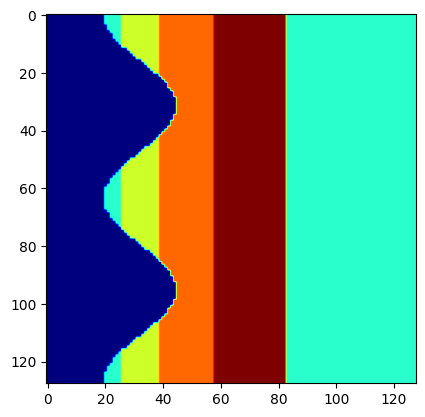

In [6]:
data_slice = data[:,1,:]
plt.imshow(data_slice, cmap='jet')

## Plotting Toolbox

The models are difficult to visualize using matplotlib alone. Fortunately there are advanced scientific 3d visualization packages available, the details of which can be found in the repo code examples: PyvistaVisualizations

Some curated constructions are available in the plot library:

*   Volume View
*   Orthogonal Slicing View
*   N-Slice View
*   One Slice View
*   Transformation View
*   Categorical View

The ones used most frequently are *Volume* and *Categorical* view for inspecting data, and Transformation view for debugging.

> 📝 **Note:**
>
> PyVista requires a virtual frame buffer to render on a remote server like Colab
>
> See https://tutorial.pyvista.org/getting-started.html


In [7]:
p = geovis.categorical_grid_view(model)
p.window_size = (640,480)
p.show()

Widget(value='<iframe src="http://localhost:63856/index.html?ui=P_0x25d3b331050_0&reconnect=auto" class="pyvis…

## Model Normalization
Can you see a problem? The model was filled past the top and there is no interface between air and ground. Models can be automatically renormalized during or after computation. The default scheme will normalize to roughly 85% fill height with some variation.

In [8]:
model.clear_data()
model.compute_model(normalize=True)
p = geovis.categorical_grid_view(model)
p.window_size = (640,480)
p.show()

Widget(value='<iframe src="http://localhost:63856/index.html?ui=P_0x25d3b2bee10_1&reconnect=auto" class="pyvis…

# Generative Layer

GeoModels can be built by hand, but the process is time consuming and requires auditing. Trying to randomize too many parameters in an entire model at the same time is not feasible, instead it is easier to find randomization schemes for single geological events. This is the concept behind `GeoWord`s, a generic class for generating history snippets.

All of the generative code is found withing the generation package, which we imported earlier as `gen`

Before moving on we have a quick look at how a `GeoWord` works in principle, by making our own custom version of one:

In [9]:
class MyNewGeoWord(gen.GeoWord):

  # Contract method that needs to be defined by all GeoWords
  def build_history(self):
    base_strata = geo.Bedrock(base=self.rng.uniform(-8.-2) , value=0)
    sediment = geo.Sedimentation(value_list=[2, 3, 4, 5], thickness_list=[1,2,3,4])
    fold2 = geo.Fold(strike =   self.rng.uniform(0,360),
                     dip =      self.rng.normal(90,10),
                     rake =     self.rng.normal(0,20),
                     period =   self.rng.uniform(5,15),
                     amplitude= self.rng.normal(0,3))
    # Inherited Methods
    self.add_process(base_strata)
    self.add_process(sediment)
    self.add_process(fold2)

A sentence is a list of `GeoWord`

In [10]:
model = geo.GeoModel(bounds=(-10, 10), resolution=128)
my_word = MyNewGeoWord()
sentence = [my_word]
history  = gen.generate_history(sentence)

#Or equivalently for a single word, call its generator:
history = MyNewGeoWord().generate()

model.add_history(history)
model.compute_model(normalize=True)
p = geovis.volview(model)
p.window_size = (320,320)
p.show()
print(model.get_history_string())

Widget(value='<iframe src="http://localhost:63856/index.html?ui=P_0x25d3f1f4cd0_2&reconnect=auto" class="pyvis…

Geological History:
1: CompoundProcess (MyNewGeoWord) with 3 sub-processes:
    1. Bedrock: with z <= -8.5 and value 0.0
    2. Sedimentation: rock type values [2, 3, 4...], and thicknesses 1.000, 2.000, 3.000..., with base = nan
    3. Fold: strike 302.0°, dip 81.6°, rake -15.1°, period 6.8,amplitude 3.9, origin ((0.00,0.00,0.00)).
2: Shift: vector [0.         0.         2.37336031]


## Sentence Generation

Now that we see how a single word works, we can use library words to make complex sentences.

A word of caution here, these library words have been designed for large scale models measured in meters. The geomodel should reflect these design bounds in mind. The design parameters for the library words is stored alongside the words.

In [11]:
bounds = (gen.BOUNDS_X, gen.BOUNDS_Y, gen.BOUNDS_Z)
model = geo.GeoModel(bounds=bounds, resolution=(128,128,64))

sentence = [gen.InfiniteSedimentTilted() , gen.FourierFold(), gen.CoarseRepeatSediment(), gen.TiltCutFill(), gen.OreDeposit(), gen.Fault(), gen.Fault(),]
history = gen.generate_history(sentence)

model.add_history(history)
model.compute_model(normalize=True)
p = geovis.volview(model)
p.window_size = (320,320)
p.show()
print(model.get_history_string())

Widget(value='<iframe src="http://localhost:63856/index.html?ui=P_0x25d3f26da90_3&reconnect=auto" class="pyvis…

Geological History:
1: CompoundProcess (InfiniteSedimentTilted) with 4 sub-processes:
    1. Bedrock: with z <= -17280.0 and value 0.0
    2. Sedimentation: rock type values [1, 3, 1...], and thicknesses 393.344, 650.036, 526.525..., with base = -17280.0
    3. Tilt: strike 131.4°, dip 21.0°,origin ((0, 0, 0))
    4. UnconformityBase: base 1000.0, value nan
2: CompoundProcess (FourierFold) with 1 sub-processes:
    1. Fold: strike 172.8°, dip 106.6°, rake 251.7°, period 10207.3,amplitude 624.5, origin ((0.00,0.00,0.00)).
3: CompoundProcess (CoarseRepeatSediment) with 1 sub-processes:
    1. Sedimentation: rock type values [3], and thicknesses 414.619, with base = nan
4: CompoundProcess (TiltCutFill) with 7 sub-processes:
    1. Tilt: strike 40.7°, dip -11.4°,origin ((0, 0, 0))
    2. Fold: strike 125.3°, dip 84.6°, rake 10.8°, period 13847.0,amplitude 208.1, origin ((0.00,0.00,0.00)).
    3. Fold: strike 215.3°, dip 87.0°, rake -5.9°, period 8506.6,amplitude 144.5, origin ((0.00,0.00,0

## Markov Chain Sentences

Some groupings of geowords can be combined to automatically generate sentences.

In [12]:
# The class has been configure to automatically parse the BOUNDS_X, Y, Z from earlier
sampler = gen.MarkovGeostoryGenerator(model_bounds = None, model_resolution = (128,128,64))

# Sample a sequence of geoword categories
sequence = sampler._build_markov_sequence()
print(f"Markov Sequence: {sequence}")

# Or build a whole model
model = sampler.generate_model()

geovis.volview(model).show()

Markov Sequence: ['BaseStrata', 'Pluton', 'Fault', 'Fold', 'End']


Widget(value='<iframe src="http://localhost:63856/index.html?ui=P_0x25d3f23e750_4&reconnect=auto" class="pyvis…

# Dataset and Dataloader

A demonstration of the dataset with a torch dataloader wrapper is shown below. The important parameters to pass are the data shape (the voxel resolution) and the model bounds. Notice that the bounds have been imported from the generative package, since those are the same ones that were used when specifying the Geowords. Larger or smaller models can be experimented with as well.

In [13]:
from torch.utils.data import DataLoader
from geogen.dataset import GeoData3DStreamingDataset

# Note that the resolution should match the bounds in aspect ratio for cubic voxels
# X or Y bounds can be reduced from standard size, but it is not recommended to decrease Z bounds
DATA_SHAPE = (128,128,64)
BOUNDS = (gen.BOUNDS_X, gen.BOUNDS_Y, gen.BOUNDS_Z)

def get_data_loader(batch_size, device, shuffle=False):
    dataset = GeoData3DStreamingDataset(
        model_resolution=DATA_SHAPE,
        model_bounds=BOUNDS,
        dataset_size=10_000,  # Number of samples in one epoch
        device=device,
    )
    dataloader = DataLoader(dataset,
                            batch_size=batch_size,
                            shuffle=shuffle,
                            num_workers=2)
    return dataloader


The **dataset** is generated on the fly, however the dataset has had an artifical set size placed on it. A model can be retrieved using indexing.

In [14]:
from torch.nn.functional import mse_loss

dataset = GeoData3DStreamingDataset(
        model_resolution=DATA_SHAPE,
        model_bounds=BOUNDS,
        dataset_size=10_000,  # Number of samples in one epoch
        device='cpu',
    )

sample1 = dataset[0]
sample2 = dataset[0]

diff = mse_loss(sample1, sample2)
print(f"MSE Diff: {diff}")



MSE Diff: 11.006048202514648
